In [39]:
from torch import tensor
import os
from tqdm import tqdm
import torch
import h5py
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [70]:
validsamples = torch.load('/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/experiments/test_residual/custom_cosine/samples_valid_one_hot_edges_coordinates_pos_encoding_pw_distance_edge_length_edge_angles_future_len_hist5_fut_0.pth')
validids = torch.load('/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/experiments/test_residual/custom_cosine/valid_ids_one_hot_edges_coordinates_pos_encoding_pw_distance_edge_length_edge_angles_future_len_hist5_fut_0.pth')

In [71]:
print(validsamples)
print(validids)

[[tensor([24, 27]), tensor([37]), tensor([4]), tensor([18]), tensor([], dtype=torch.int64), tensor([29, 32]), tensor([], dtype=torch.int64), tensor([38]), tensor([3]), tensor([], dtype=torch.int64), tensor([], dtype=torch.int64), tensor([], dtype=torch.int64), tensor([], dtype=torch.int64), tensor([], dtype=torch.int64), tensor([ 9, 11]), tensor([], dtype=torch.int64), tensor([26]), tensor([], dtype=torch.int64), tensor([12, 13, 27]), tensor([4])], [tensor([16])]]
[[2, 4, 3, 6, None, 1, None, 3, 0, None, None, None, None, None, 5, None, 1, None, 1, 4], [4]]


## Enter Dataset, transition matrix, and features

In [40]:
folder = '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/experiments'
dataset = 'pneuma'  # pneuma, tdrive, geolife, munich
model = 'residual'  # residual, GAT, MLP
transition_matrix = 'custom'    # custom, marginal_prior
noising = 'cosine'  # cosine, linear
features = 'one_hot_edges_coordinates_pos_encoding_pw_distance_edge_length_edge_angles_num_pred_edges'
history = 5
future = 10

# Single sample
Metrics

# Multiplte sample
Metrics

## Load Data

In [41]:
sample_list = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/samples_one_shot_{features}_hist{history}_fut_{future}.pth')
valid_ids = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/valid_ids_{features}_hist{history}_fut_{future}.pth')
samples_raw = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/samples_raw_{features}_hist{history}_fut_{future}.pth')
samples_valid = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/samples_valid_{features}_hist{history}_fut_{future}.pth')
ground_truth_hist = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/gt_hist_{features}_hist{history}_fut_{future}.pth')
ground_truth_fut = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/gt_fut_{features}_hist{history}_fut_{future}.pth')

In [42]:
res = {'sample_list': sample_list, 'samples_valid': samples_valid, 'valid_ids': valid_ids, 'samples_raw': samples_raw, 'ground_truth_hist': ground_truth_hist, 'ground_truth_fut': ground_truth_fut}

## Load Graph

In [43]:
def load_new_format(file_path, device):
        paths = []
        with h5py.File(file_path, 'r') as new_hf:
            node_coordinates = torch.tensor(new_hf['graph']['node_coordinates'][:], dtype=torch.float, device=device)
            #edges = torch.tensor(new_hf['graph']['edges'][:], dtype=torch.long, device=device)
            edges = new_hf['graph']['edges'][:]
            edge_coordinates = node_coordinates[edges]
            nodes = [(i, {'pos': torch.tensor(pos, device=device)}) for i, pos in enumerate(node_coordinates)]
            #edges = [(torch.tensor(edge[0], device=device), torch.tensor(edge[1], device=device)) for edge in edges]
            edges = [tuple(edge) for edge in edges]

            '''nodes = [(i, {'pos': tuple(pos)}) for i, pos in enumerate(node_coordinates)]
            edges = [tuple(edge) for edge in edges]'''

            for i in tqdm(new_hf['trajectories'].keys()):
                path_group = new_hf['trajectories'][i]
                path = {attr: torch.tensor(path_group[attr][()], device=device) for attr in path_group.keys() if attr in ['coordinates', 'edge_idxs', 'edge_orientations']}
                # path = {attr: path_group[attr][()] for attr in path_group.keys()}
                paths.append(path)
            
        return paths, nodes, edges, edge_coordinates
    
paths, nodes, edges, edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/{dataset}_val.h5', 'cpu')
indexed_edges = [((start, end), index) for index, (start, end) in enumerate(edges)]
G = nx.Graph()
G.add_nodes_from(nodes)
for (start, end), index in indexed_edges:
        G.add_edge(start, end, index=index, default_orientation=(start, end))

/tmp/ipykernel_1733969/3098842790.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nodes = [(i, {'pos': torch.tensor(pos, device=device)}) for i, pos in enumerate(node_coordinates)]
  0%|          | 0/3874 [00:00<?, ?it/s]

100%|██████████| 3874/3874 [00:01<00:00, 1978.72it/s]


In [66]:
def check_sample(sample):
    """
    Check if the sample is valid, i.e. connected, acyclical, and no splits.

    :param sample: A list of predicted edge indices.
    """
    if len(sample) == 0:
        print("error")
        return True, sample
    
    else:
        # Check connectivity
        def is_connected_sequence(edge_indices, graph):
            if len(edge_indices) <= 1:
                return True
            edges = [indexed_edges[idx][0] for idx in edge_indices]  # Adjust this if your graph structure differs

            # Create a subgraph from these edges
            subgraph = nx.Graph()
            subgraph.add_edges_from(edges)
            return nx.is_connected(subgraph)
        
        # Check acyclical
        def is_acyclical_sequence(edge_indices, graph):
            if len(edge_indices) <= 1:
                return True
            edges = indexed_edges
            subgraph_nodes = []
            subgraph_edges = []
            for idx in edge_indices:
                edge = edges[idx][0]  # get the node tuple for each edge
                subgraph_nodes.append(edge)
                subgraph_edges.append(edge)

            subgraph = nx.Graph()
            subgraph.add_edges_from(subgraph_edges)
            
            has_cycle = nx.cycle_basis(subgraph)
            print("acyclical", len(has_cycle) == 0)
            return len(has_cycle) == 0
        
        # Check no splits
        def is_not_split(edge_indices, graph):
            if len(edge_indices) <= 1:
                return True
            edges = indexed_edges
            subgraph_nodes = set()
            subgraph_edges = []
            for idx in edge_indices:
                edge = edges[idx][0]  # get the node tuple for each edge
                subgraph_nodes.update(edge)
                subgraph_edges.append(edge)

            # Create a directed version of the subgraph to check for cycles
            graph = nx.Graph()
            graph.add_nodes_from(subgraph_nodes)
            graph.add_edges_from(subgraph_edges)
            
            if any(graph.degree(node) > 2 for node in graph.nodes()):
                print("split")
                return False
            else:
                print("no split")
                return True
            
        connected = is_connected_sequence(sample, G)
        acyclical = is_acyclical_sequence(sample, G)
        no_splits = is_not_split(sample, G)
        
        #print("Connected", connected)
        #print("Acyclical", acyclical)
        #print("No splits", no_splits)
        if connected and acyclical and no_splits:
            return True, sample
        else:
            return False, sample

KeyError: 'index'

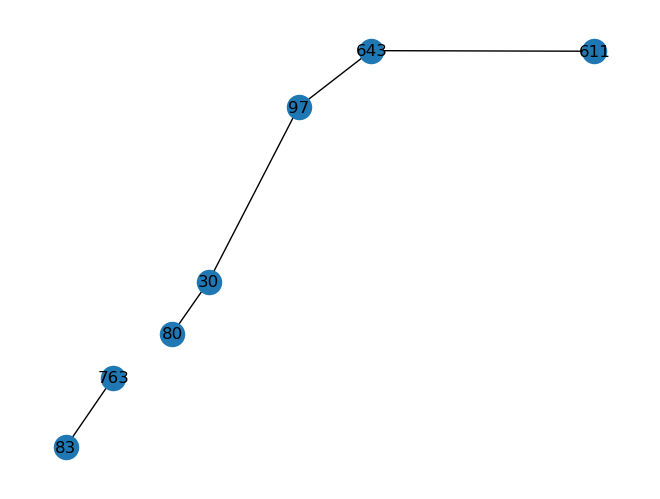

In [67]:
check_sample(torch.tensor([  59,  187, 1046, 1101, 1299]))

In [59]:
print(indexed_edges[59][0])
print(indexed_edges[187][0])
print(indexed_edges[1046][0])
print(indexed_edges[1101][0])
print(indexed_edges[1299][0])
print("\n")
print(edges[59])
print(edges[187])
print(edges[1046])
print(edges[1101])
print(edges[1299])
print("\n")
g_edges = list(G.edges)
print(g_edges[59])
print(g_edges[187])
print(g_edges[1046])
print(g_edges[1101])
print(g_edges[1299])

(80, 30)
(97, 30)
(611, 643)
(97, 643)
(83, 763)


(80, 30)
(97, 30)
(611, 643)
(97, 643)
(83, 763)


(21, 47)
(81, 136)
(557, 559)
(586, 588)
(724, 738)


## Plot Single Sample

In [32]:
def plot_paths_random(ground_truth_hist, ground_truth_fut, samples, edge_coordinates, num_paths_to_plot=4, zoom_in=True, valid=False, valid_ids=None):
    # Setup the subplot layout based on num_paths_to_plot
    fig, axs = plt.subplots(num_paths_to_plot, 1, figsize=(10, 5 * num_paths_to_plot), squeeze=False)
    axs = axs.flatten()  # Flatten in case of a single subplot to standardize indexing

    path_count = 0
    while path_count < num_paths_to_plot:
        batch_idx = torch.randint(0, len(ground_truth_hist), (1,)).item()
        idx = torch.randint(0, len(ground_truth_hist[batch_idx]), (1,)).item()
        if valid:
            print("valid id",valid_ids[batch_idx][idx])
            print("Sample ids", samples[batch_idx][idx])
            if valid_ids[batch_idx][idx] is None:
                continue
        
        ax = axs[path_count]
        if idx >= len(ground_truth_hist[batch_idx]):
            continue
        
        if zoom_in:
            all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx], samples[batch_idx][idx]])
            if all_edges.numel() > 0:
                all_coords = edge_coordinates[all_edges].view(-1, 2)
                xmin, xmax = all_coords.min(0)[0], all_coords.max(0)[0]
                margin = (xmax - xmin) * 0.1
                xmin -= margin
                xmax += margin
                ax.set_xlim(xmin[0].item(), xmax[0].item())
                ax.set_ylim(xmin[1].item(), xmax[1].item())
        # Plot all edges as background
        for edge in edge_coordinates:
            ax.plot(edge[:, 0], edge[:, 1], color='grey', linewidth=0.5)
        
        # Define the plot_trajectory within this function to ensure it uses 'ax'
        def plot_trajectory(edge_indices, color, label):
            added_label = False  # Flag to add label only once
            if edge_indices.dim() == 2:
                edge_indices = edge_indices.squeeze(0)
            if edge_indices.numel() > 0:
                for edge_idx in edge_indices:
                    edge = edge_coordinates[edge_idx]
                    line_style = ':' if label == 'Predicted Future' else '-'  # Use dotted lines for 'Predicted Future'
                    lw = 4 if label == 'Predicted Future' else 2  # Use thicker lines for 'Predicted Future'
                    if not added_label:
                        ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style, label=label)
                        added_label = True
                    else:
                        ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style)

        plot_trajectory(ground_truth_hist[batch_idx][idx], 'blue', 'History')
        plot_trajectory(ground_truth_fut[batch_idx][idx], 'green', 'Ground Truth Future')
        plot_trajectory(samples[batch_idx][idx], 'red', 'Predicted Future')

        ax.set_title(f'Trajectory {idx+1} of batch {batch_idx+1}')
        ax.legend(loc='upper left', fontsize=16)
        ax.axis('off')

        path_count += 1  # Increment the path counter
    plt.tight_layout()
    plt.show()

#plot_paths_random(res['ground_truth_hist'], res['ground_truth_fut'], res['sample_list'], edge_coordinates, num_paths_to_plot=10, zoom_in=True)

## Plot Valid Samples

valid id 3
Sample ids tensor([464, 475, 553, 555])
valid id 0
Sample ids tensor([  59,  187, 1046, 1101, 1299])
valid id 0
Sample ids tensor([488, 491, 502])
valid id None
Sample ids tensor([], dtype=torch.int64)
valid id 6
Sample ids tensor([  56,  145,  187, 1046, 1101])
valid id 7
Sample ids tensor([ 49,  81, 102, 111, 113])
valid id 0
Sample ids tensor([466, 468, 471, 474, 477])
valid id 1
Sample ids tensor([482, 486, 506, 515, 519, 561, 564, 566, 570, 606, 635, 649])
valid id 7
Sample ids tensor([ 42,  88,  90, 100, 197])
valid id 2
Sample ids tensor([159, 248, 251])
valid id 6
Sample ids tensor([ 46, 464, 465, 475, 553, 555, 617, 620, 723])


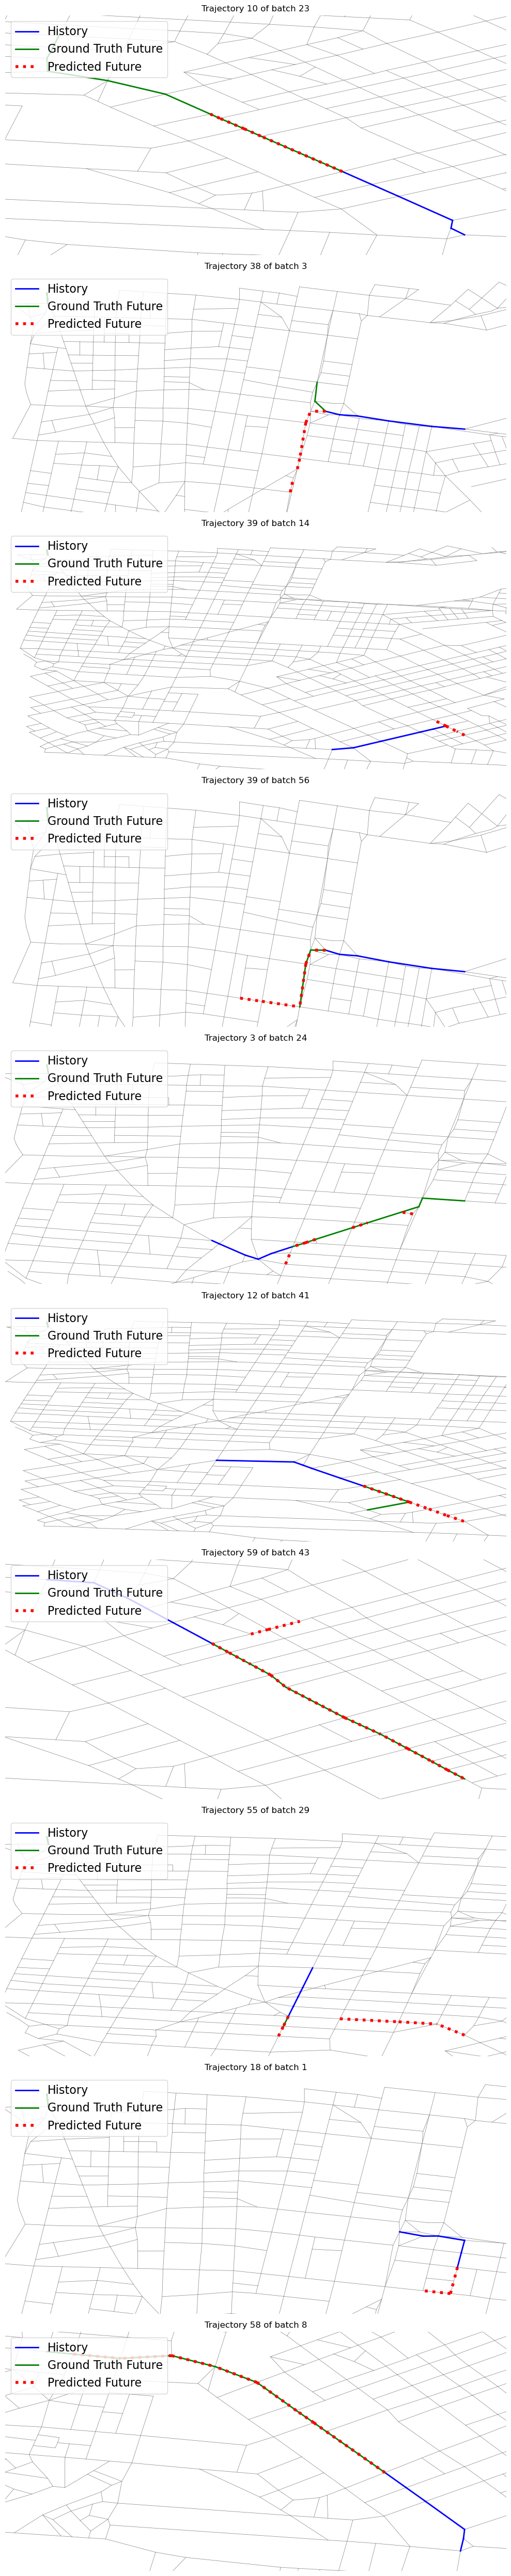

In [33]:
plot_paths_random(res['ground_truth_hist'], res['ground_truth_fut'], res['samples_valid'], edge_coordinates, num_paths_to_plot=10, zoom_in=True, valid=True, valid_ids=res['valid_ids'])

## Plot Path Density Random

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import matplotlib.lines as mlines

def plot_path_density_random(ground_truth_hist, ground_truth_fut, samples, edge_coordinates, num_paths_to_plot=4, random=False, start_id=0, zoom_in=True):
    # Setup the subplot layout based on num_paths_to_plot
    fig, axs = plt.subplots(num_paths_to_plot, 1, figsize=(10, 5 * num_paths_to_plot), squeeze=False)
    axs = axs.flatten()  # Flatten in case of a single subplot to standardize indexing

    path_count = 0
    path_count = 0
    while path_count < num_paths_to_plot:
        batch_idx = torch.randint(0, len(ground_truth_hist), (1,)).item()
        idx = torch.randint(0, len(ground_truth_hist[batch_idx]), (1,)).item()
        
        ax = axs[path_count]
        if idx >= len(ground_truth_hist[batch_idx]):
            continue

        # Configure zooming in on relevant trajectories
        all_samples_edges = torch.cat([sample[idx] for sample in samples[batch_idx]])
        all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx], all_samples_edges])
        if zoom_in:
            # all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx]] + [sample[idx] for sample in samples[batch_idx]])
            if all_edges.numel() > 0:
                all_coords = edge_coordinates[all_edges].view(-1, 2)
                xmin, xmax = all_coords.min(0)[0], all_coords.max(0)[0]
                margin = (xmax - xmin) * 0.1
                xmin -= margin
                xmax += margin
                ax.set_xlim(xmin[0].item(), xmax[0].item())
                ax.set_ylim(xmin[1].item(), xmax[1].item())

        # Plot background edges
        for edge in edge_coordinates:
            ax.plot(edge[:, 0], edge[:, 1], color='grey', linewidth=0.5)
            
        # Track how often each edge is used in samples
        edge_count = {}
        for sample in samples[batch_idx]:
            for edge_idx in sample[idx]:
                edge_count[edge_idx.item()] = edge_count.get(edge_idx.item(), 0) + 1

        max_count = max(edge_count.values()) if edge_count else 1
                
                
        # Define the plot_trajectory within this function to ensure it uses 'ax'
        def plot_trajectory(edge_indices, color, label):
            if isinstance(edge_indices, dict):
                edge_indices = edge_indices.items()
                added_label = False  # Flag to add label only once
                for edge_idx, count in edge_indices:
                    edge = edge_coordinates[edge_idx]
                    ax.plot(edge[:, 0], edge[:, 1], color='red', linewidth=2 + 3 * (count / max_count), alpha=0.3 + 0.7 * (count / max_count), linestyle='--')
            else:
                added_label = False  # Flag to add label only once
                if edge_indices.dim() == 2:
                    edge_indices = edge_indices.squeeze(0)
                if edge_indices.numel() > 0:
                    for edge_idx in edge_indices:
                        edge = edge_coordinates[edge_idx]
                        line_style = '-'
                        lw = 2
                        ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style, label=label)

        plot_trajectory(ground_truth_hist[batch_idx][idx], 'blue', 'History')
        plot_trajectory(ground_truth_fut[batch_idx][idx], 'green', 'Ground Truth Future')
        plot_trajectory(edge_count, 'red', 'Predicted Future')
        
        custom_handle1 = mlines.Line2D([], [], color='blue', linestyle='-', markersize=15, label='History')
        custom_handle2 = mlines.Line2D([], [], color='green', linestyle='-', markersize=15, label='Ground Truth Future')
        custom_handle3 = mlines.Line2D([], [], color='red', linestyle='--', markersize=15, label='Predicted Future')


        ax.set_title(f'Trajectory {idx+1} of batch {batch_idx+1}')
        ax.legend(handles=[custom_handle1, custom_handle2, custom_handle3], loc='upper left', fontsize=12)
        ax.axis('off')

        path_count += 1  # Increment the path counter

    plt.tight_layout()
    plt.show()

plot_path_density_random(res['ground_truth_hist'], res['ground_truth_fut'], res['samples_raw'], edge_coordinates, num_paths_to_plot=10, zoom_in=True)

## Plot Multiple Samples

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch

def plot_multiple_paths_random(ground_truth_hist, ground_truth_fut, samples, edge_coordinates, num_paths_to_plot=4, random=False, start_id=0, zoom_in=True):
    # Setup the subplot layout based on num_paths_to_plot
    fig, axs = plt.subplots(num_paths_to_plot, 1, figsize=(10, 5 * num_paths_to_plot), squeeze=False)
    axs = axs.flatten()  # Flatten in case of a single subplot to standardize indexing

    path_count = 0
    path_count = 0
    while path_count < num_paths_to_plot:
        batch_idx = torch.randint(0, len(ground_truth_hist), (1,)).item()
        idx = torch.randint(0, len(ground_truth_hist[batch_idx]), (1,)).item()
        
        ax = axs[path_count]
        if idx >= len(ground_truth_hist[batch_idx]):
            continue

        # Configure zooming in on relevant trajectories
        all_samples_edges = torch.cat([sample[idx] for sample in samples[batch_idx]])
        all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx], all_samples_edges])
        if zoom_in:
            # all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx]] + [sample[idx] for sample in samples[batch_idx]])
            if all_edges.numel() > 0:
                all_coords = edge_coordinates[all_edges].view(-1, 2)
                xmin, xmax = all_coords.min(0)[0], all_coords.max(0)[0]
                margin = (xmax - xmin) * 0.1
                xmin -= margin
                xmax += margin
                ax.set_xlim(xmin[0].item(), xmax[0].item())
                ax.set_ylim(xmin[1].item(), xmax[1].item())

        # Plot background edges
        for edge in edge_coordinates:
            ax.plot(edge[:, 0], edge[:, 1], color='grey', linewidth=0.5)

            # Define the plot_trajectory within this function to ensure it uses 'ax'
            def plot_trajectory(edge_indices, color, label):
                added_label = False  # Flag to add label only once
                if edge_indices.dim() == 2:
                    edge_indices = edge_indices.squeeze(0)
                if edge_indices.numel() > 0:
                    for edge_idx in edge_indices:
                        edge = edge_coordinates[edge_idx]
                        line_style = '-' if 'Predicted' in label else '-'  # Use dotted lines for 'Predicted Future'
                        lw = 4 if 'Predicted' in label else 2
                        alpha = 0.5 if 'Predicted' in label else 1
                        if not added_label:
                            ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style, label=label)
                            added_label = True
                        else:
                            ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style)

            plot_trajectory(ground_truth_hist[batch_idx][idx], 'blue', 'History')
            plot_trajectory(ground_truth_fut[batch_idx][idx], 'green', 'Ground Truth Future')
            
            # Plot all samples for this data point
            sample_colors = cm.get_cmap('tab10', len(samples[batch_idx]))
            for j, sample in enumerate(samples[batch_idx]):
                plot_trajectory(sample[idx], sample_colors(j), f'Predicted Future {j+1}')

            ax.set_title(f'Trajectory {idx+1} of batch {batch_idx+1}')
            ax.legend(loc='upper left')
            ax.axis('off')

            path_count += 1  # Increment the path counter

    plt.tight_layout()
    plt.show()

plot_multiple_paths_random(res['ground_truth_hist'], res['ground_truth_fut'], res['samples_raw'], edge_coordinates, num_paths_to_plot=10, zoom_in=True)

In [ ]:
'''def plot_paths(ground_truth_hist, ground_truth_fut, samples, edge_coordinates, num_paths_to_plot=4, random=False, start_id=0, zoom_in=True):
    # Setup the subplot layout based on num_paths_to_plot
    fig, axs = plt.subplots(num_paths_to_plot, 1, figsize=(10, 5 * num_paths_to_plot), squeeze=False)
    axs = axs.flatten()  # Flatten in case of a single subplot to standardize indexing

    path_count = 0
    for batch_idx in range(len(ground_truth_hist)):
        # Determine the starting index
        start_idx = torch.randint(0, len(ground_truth_hist[batch_idx]) - num_paths_to_plot + 1, (1,)).item() if random else start_id
        for i in range(len(ground_truth_hist[batch_idx])):
            if path_count >= num_paths_to_plot:
                break  # Stop if we have plotted the desired number of paths

            ax = axs[path_count]
            idx = start_idx + i
            if idx >= len(ground_truth_hist[batch_idx]):
                continue  # Prevent indexing beyond the number of samples

            # Configure zooming in on relevant trajectories
            if zoom_in:
                all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx], samples[batch_idx][idx]])
                if all_edges.numel() > 0:
                    all_coords = edge_coordinates[all_edges].view(-1, 2)
                    xmin, xmax = all_coords.min(0)[0], all_coords.max(0)[0]
                    margin = (xmax - xmin) * 0.1
                    xmin -= margin
                    xmax += margin
                    ax.set_xlim(xmin[0].item(), xmax[0].item())
                    ax.set_ylim(xmin[1].item(), xmax[1].item())

            # Plot all edges as background
            for edge in edge_coordinates:
                ax.plot(edge[:, 0], edge[:, 1], color='grey', linewidth=0.5)

            # Define the plot_trajectory within this function to ensure it uses 'ax'
            def plot_trajectory(edge_indices, color, label):
                added_label = False  # Flag to add label only once
                if edge_indices.dim() == 2:
                    edge_indices = edge_indices.squeeze(0)
                if edge_indices.numel() > 0:
                    for edge_idx in edge_indices:
                        edge = edge_coordinates[edge_idx]
                        line_style = ':' if label == 'Predicted Future' else '-'  # Use dotted lines for 'Predicted Future'
                        lw = 4 if label == 'Predicted Future' else 2  # Use thicker lines for 'Predicted Future'
                        if not added_label:
                            ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style, label=label)
                            added_label = True
                        else:
                            ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style)

            plot_trajectory(ground_truth_hist[batch_idx][idx], 'blue', 'History')
            plot_trajectory(ground_truth_fut[batch_idx][idx], 'green', 'Ground Truth Future')
            plot_trajectory(samples[batch_idx][idx], 'red', 'Predicted Future')

            ax.set_title(f'Trajectory {idx+1} of batch {batch_idx+1}')
            ax.legend(loc='upper left', fontsize=16)
            ax.axis('off')

            path_count += 1  # Increment the path counter

    plt.tight_layout()
    plt.show()

plot_paths(res['ground_truth_hist'], res['ground_truth_fut'], res['sample_list'], edge_coordinates, num_paths_to_plot=70, zoom_in=True)'''

In [ ]:
'''import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import matplotlib.lines as mlines

def plot_path_density(ground_truth_hist, ground_truth_fut, samples, edge_coordinates, num_paths_to_plot=4, random=False, start_id=0, zoom_in=True):
    # Setup the subplot layout based on num_paths_to_plot
    fig, axs = plt.subplots(num_paths_to_plot, 1, figsize=(10, 5 * num_paths_to_plot), squeeze=False)
    axs = axs.flatten()  # Flatten in case of a single subplot to standardize indexing

    path_count = 0
    for batch_idx in range(len(ground_truth_hist)):
        # Determine the starting index
        start_idx = torch.randint(0, len(ground_truth_hist[batch_idx]) - num_paths_to_plot + 1, (1,)).item() if random else start_id
        for i in range(len(ground_truth_hist[batch_idx])):
            if path_count >= num_paths_to_plot:
                break  # Stop if we have plotted the desired number of paths

            ax = axs[path_count]
            idx = start_idx + i
            if idx >= len(ground_truth_hist[batch_idx]):
                continue  # Prevent indexing beyond the number of samples

            # Configure zooming in on relevant trajectories
            all_samples_edges = torch.cat([sample[idx] for sample in samples[batch_idx]])
            all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx], all_samples_edges])
            if zoom_in:
                # all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx]] + [sample[idx] for sample in samples[batch_idx]])
                if all_edges.numel() > 0:
                    all_coords = edge_coordinates[all_edges].view(-1, 2)
                    xmin, xmax = all_coords.min(0)[0], all_coords.max(0)[0]
                    margin = (xmax - xmin) * 0.1
                    xmin -= margin
                    xmax += margin
                    ax.set_xlim(xmin[0].item(), xmax[0].item())
                    ax.set_ylim(xmin[1].item(), xmax[1].item())

            # Plot background edges
            for edge in edge_coordinates:
                ax.plot(edge[:, 0], edge[:, 1], color='grey', linewidth=0.5)
                
            # Track how often each edge is used in samples
            edge_count = {}
            for sample in samples[batch_idx]:
                for edge_idx in sample[idx]:
                    edge_count[edge_idx.item()] = edge_count.get(edge_idx.item(), 0) + 1

            max_count = max(edge_count.values()) if edge_count else 1
                
                
            # Define the plot_trajectory within this function to ensure it uses 'ax'
            def plot_trajectory(edge_indices, color, label):
                if isinstance(edge_indices, dict):
                    edge_indices = edge_indices.items()
                    added_label = False  # Flag to add label only once
                    for edge_idx, count in edge_indices:
                        edge = edge_coordinates[edge_idx]
                        ax.plot(edge[:, 0], edge[:, 1], color='red', linewidth=2 + 3 * (count / max_count), alpha=0.3 + 0.7 * (count / max_count), linestyle='--')
                else:
                    added_label = False  # Flag to add label only once
                    if edge_indices.dim() == 2:
                        edge_indices = edge_indices.squeeze(0)
                    if edge_indices.numel() > 0:
                        for edge_idx in edge_indices:
                            edge = edge_coordinates[edge_idx]
                            line_style = '-'
                            lw = 2
                            ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style, label=label)

            plot_trajectory(ground_truth_hist[batch_idx][idx], 'blue', 'History')
            plot_trajectory(ground_truth_fut[batch_idx][idx], 'green', 'Ground Truth Future')
            plot_trajectory(edge_count, 'red', 'Predicted Future')
            
            custom_handle1 = mlines.Line2D([], [], color='blue', linestyle='-', markersize=15, label='History')
            custom_handle2 = mlines.Line2D([], [], color='green', linestyle='-', markersize=15, label='Ground Truth Future')
            custom_handle3 = mlines.Line2D([], [], color='red', linestyle='--', markersize=15, label='Predicted Future')


            ax.set_title(f'Trajectory {idx+1} of batch {batch_idx+1}')
            ax.legend(handles=[custom_handle1, custom_handle2, custom_handle3], loc='upper left', fontsize=12)
            ax.axis('off')

            path_count += 1  # Increment the path counter

    plt.tight_layout()
    plt.show()

plot_path_density(res['ground_truth_hist'], res['ground_truth_fut'], res['samples_raw'], edge_coordinates, num_paths_to_plot=50, zoom_in=True)'''

In [ ]:
'''import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch

def plot_multiple_paths(ground_truth_hist, ground_truth_fut, samples, edge_coordinates, num_paths_to_plot=4, random=False, start_id=0, zoom_in=True):
    # Setup the subplot layout based on num_paths_to_plot
    fig, axs = plt.subplots(num_paths_to_plot, 1, figsize=(10, 5 * num_paths_to_plot), squeeze=False)
    axs = axs.flatten()  # Flatten in case of a single subplot to standardize indexing

    path_count = 0
    for batch_idx in range(len(ground_truth_hist)):
        # Determine the starting index
        start_idx = torch.randint(0, len(ground_truth_hist[batch_idx]) - num_paths_to_plot + 1, (1,)).item() if random else start_id
        for i in range(len(ground_truth_hist[batch_idx])):
            if path_count >= num_paths_to_plot:
                break  # Stop if we have plotted the desired number of paths

            ax = axs[path_count]
            idx = start_idx + i
            if idx >= len(ground_truth_hist[batch_idx]):
                continue  # Prevent indexing beyond the number of samples

            # Configure zooming in on relevant trajectories
            if zoom_in:
                all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx]] + [sample[idx] for sample in samples[batch_idx]])
                if all_edges.numel() > 0:
                    all_coords = edge_coordinates[all_edges].view(-1, 2)
                    xmin, xmax = all_coords.min(0)[0], all_coords.max(0)[0]
                    margin = (xmax - xmin) * 0.1
                    xmin -= margin
                    xmax += margin
                    ax.set_xlim(xmin[0].item(), xmax[0].item())
                    ax.set_ylim(xmin[1].item(), xmax[1].item())

            # Plot all edges as background
            for edge in edge_coordinates:
                ax.plot(edge[:, 0], edge[:, 1], color='grey', linewidth=0.5)

            # Define the plot_trajectory within this function to ensure it uses 'ax'
            def plot_trajectory(edge_indices, color, label):
                added_label = False  # Flag to add label only once
                if edge_indices.dim() == 2:
                    edge_indices = edge_indices.squeeze(0)
                if edge_indices.numel() > 0:
                    for edge_idx in edge_indices:
                        edge = edge_coordinates[edge_idx]
                        line_style = '-' if 'Predicted' in label else '-'  # Use dotted lines for 'Predicted Future'
                        lw = 4 if 'Predicted' in label else 2
                        alpha = 0.5 if 'Predicted' in label else 1
                        if not added_label:
                            ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style, label=label)
                            added_label = True
                        else:
                            ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style)

            plot_trajectory(ground_truth_hist[batch_idx][idx], 'blue', 'History')
            plot_trajectory(ground_truth_fut[batch_idx][idx], 'green', 'Ground Truth Future')
            
            # Plot all samples for this data point
            sample_colors = cm.get_cmap('tab10', len(samples[batch_idx]))
            for j, sample in enumerate(samples[batch_idx]):
                plot_trajectory(sample[idx], sample_colors(j), f'Predicted Future {j+1}')

            ax.set_title(f'Trajectory {idx+1} of batch {batch_idx+1}')
            ax.legend(loc='upper left')
            ax.axis('off')

            path_count += 1  # Increment the path counter

    plt.tight_layout()
    plt.show()

plot_multiple_paths(res['ground_truth_hist'], res['ground_truth_fut'], res['samples_raw'], edge_coordinates, num_paths_to_plot=50, zoom_in=True)'''